# Hackathon SCOR 2025 — Prévention Nutritionnelle de la Dépression
#Master 2 Probabilités et Statistiques des Nouvelles Données (2024–2025)
#Université Gustave Eiffel
#Participants : Abdelli, Da Fonseca, Gnanhoue, Sagette, Pina



#🎯Objectif du projet
#Dans le cadre du hackathon organisé par SCOR, notre objectif est de construire un modèle prédictif capable d’estimer le risque de dépression modérée à sévère à partir de données nutritionnelles, démographiques et médicales issues d'une base américaine de santé publique (type NHANES).

#Nous cherchons à répondre à la problématique suivante :

#"Peut-on prédire, à partir du régime alimentaire et des caractéristiques individuelles, la probabilité qu’un individu souffre d’une forme modérée à sévère de dépression ?"

#📌 Contexte
#La dépression constitue un enjeu majeur de santé publique. La nutrition et le mode de vie sont désormais reconnus comme des facteurs influents. En exploitant des données tabulaires riches (habitudes alimentaires, traitements antidépresseurs, indicateurs de santé, etc.), ce projet vise à mettre en lumière les variables les plus déterminantes pour la prévention ciblée de la dépression.



In [42]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# pandas : pour la manipulation de tableaux de données
import pandas as pd

# matplotlib : bibliothèque de base pour les graphiques
import matplotlib.pyplot as plt

# numpy : bibliothèque pour le calcul numérique
import numpy as np

# seaborn : bibliothèque de visualisation avancée basée sur matplotlib, utile pour des graphes plus esthétiques
import seaborn as sns

from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import classification_report, accuracy_score # classification_report, accuracy_score pour évaluer la performance du modèle.

In [44]:
#  Chargement du fichier train_x.csv depuis Google Drive
df_train = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/data_nut_train.csv',

    #  Remplacement des valeurs manquantes : on considère ces chaînes comme des valeurs nulles
    na_values=["", " ", "NA", "??", "-", "--", "nan"]
)

In [45]:
df_train

,Unnamed: 0,Respondent sequence number,year,phq_little_interest_in_doing_something,phq_feeling_down,phq_trouble_sleeping,phq_feeling_tired_little_energy,phq_poor_appetite_or_overeating,phq_feeling_bad_about_yourself,phq_trouble_concentrating_on_things,...,PFA 22:6 (Docosahexaenoic) (gm),Gender,Age band,PIR band,Marital Status,Education level,BMI,Antidepressants,N antidepressants,Days since Antidepressants
0,13566,32164,2005-2006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0875,Male,"1. [20, 30[",3. Higher 1.85,1. Married/Living with partner,2. High School Grad,22.08,0,0,0
1,13373,31742,2005-2006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0050,Female,"1. [20, 30[",2. Between 1.30-1.85,3. Never Married,3. More Than High School Grad,24.15,0,0,0
2,25891,55239,2009-2010,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0005,Female,"5. [60, 70[",2. Between 1.30-1.85,3. Never Married,1. Less Than High School,26.65,0,0,0
3,8905,132288,2021-2023,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0385,Male,"6. [70, 80[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,23.01,0,0,0
4,4096,117250,2017-2020,0.0,0.0,3.0,1.0,2.0,0.0,0.0,...,0.0010,Female,"5. [60, 70[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,36.06,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36455,28430,59615,2009-2010,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0805,Male,"6. [70, 80[",1. Under 1.30,2. Widowed/Divorced/Separated,3. More Than High School Grad,29.24,1,1,122
36456,30098,62589,2011-2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0045,Female,"6. [70, 80[",3. Higher 1.85,2. Widowed/Divorced/Separated,3. More Than High School Grad,24.77,0,0,0
36457,43358,89470,2015-2016,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0105,Female,"3. [40, 50[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,21.42,0,0,0
36458,14170,33478,2005-2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0235,Female,"6. [70, 80[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,23.96,0,0,0


#Remplissage des colonnes numériques manquantes avec XGBoost
#Certaines colonnes numériques du dataset contiennent des valeurs manquantes (NaN). Pour les compléter de manière intelligente, nous utilisons un classifieur XGBoost, en transformant temporairement les valeurs numériques continues en classes discrètes. Voici les étapes suivies dans notre fonction personnalisée fill_missing_xgb_numeric :

#Méthodologie
Séparation des données :

On sépare les lignes qui ont une valeur connue pour la colonne cible (df_notna) et celles qui sont manquantes (df_nan).

#Discrétisation temporaire :

On transforme chaque valeur réelle unique de la colonne cible en une classe entière. Cette étape est nécessaire car nous utilisons XGBClassifier, un modèle de classification.

#Équilibrage du jeu de données :

Pour éviter que le modèle soit biaisé par une classe trop fréquente, on réduit la taille de la classe majoritaire via un sous-échantillonnage.

On garde toutes les autres classes (minorité) et on ajoute aléatoirement un échantillon réduit de la classe dominante.

#Pondération des classes :

On applique un poids plus élevé à la classe majoritaire afin de compenser sa réduction artificielle lors de l’entraînement.

#Préparation des données :

Les variables catégorielles sont converties en format category, ce qui est requis par XGBoost.

Entraînement du modèle XGBClassifier sur les données équilibrées pondérées.

#Prédiction des valeurs manquantes :

Le modèle est utilisé pour prédire la classe (et donc la valeur réelle associée) pour chaque ligne où la colonne est manquante.

#Restauration des valeurs originales :

Les prédictions discrètes sont reconverties en leurs valeurs réelles grâce à l’inverse du mapping.

#Injection des résultats dans la base :

On remplace les NaN par les valeurs prédites.

#Évaluation du modèle (facultative) :

On affiche la performance du modèle (accuracy, precision, recall, F1-score) sur les données d'entraînement équilibrées.

In [46]:
df_train_num = df_train.select_dtypes(include=['number'])
for col in df_train_num.columns:
    if df_train_num[col].isnull().sum()>0 :
      print(f"{col} {df_train_num[col].isnull().sum()}")

phq_little_interest_in_doing_something 2270
phq_feeling_down 2277
phq_trouble_sleeping 2279
phq_feeling_tired_little_energy 2282
phq_poor_appetite_or_overeating 2283
phq_feeling_bad_about_yourself 2286
phq_trouble_concentrating_on_things 2288
phq_moving_or_speaking_slowly_or_fast 2288
phq_thought_would_be_better_dead 2292
Dietary two-day sample weight 2077
BMI 421


In [47]:
def fill_missing_xgb_numeric(df, target_col, under_factor=5):
    from sklearn.utils import shuffle # shuffle pour mélanger les données équilibrées

    print(f"\n Traitement de la colonne : {target_col}")
    # On isole les lignes qu’on utilisera pour entraîner (non-NaN) et celles à prédire (NaN)
    df_notna = df[df[target_col].notna()]
    df_nan = df[df[target_col].isna()]

    #Puisqu'on utilise un classifieur (XGBoostClassifier), on convertit les valeurs numériques continues en classes entières
    #value_mapping transforme une valeur réelle (ex. 12.3) en classe (ex. 0)
    #inverse_mapping permet de revenir à la valeur réelle une fois les prédictions faites

    original_values = sorted(df_notna[target_col].unique())
    value_mapping = {v: i for i, v in enumerate(original_values)}
    inverse_mapping = {i: v for v, i in value_mapping.items()}
    df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)

    # On identifie la classe majoritaire pour éviter un déséquilibre qui fausserait le modèle
    class_counts = df_notna['target_mapped'].value_counts()
    majority_class = class_counts.idxmax()
    minority_classes = [c for c in class_counts.index if c != majority_class]
    # On garde toutes les classes minoritaires mais on réduit la taille de la classe majoritaire pour équilibrer le jeu d’entraînement

    df_majority = df_notna[df_notna['target_mapped'] == majority_class]
    df_minority = df_notna[df_notna['target_mapped'].isin(minority_classes)]

    # Sous-échantillonnage majoritaire
    df_majority_under = df_majority.sample(
        min(len(df_minority) * under_factor, len(df_majority)),
        random_state=42
    )
    #Fusion des deux groupes (majorité réduite + minorités), puis mélange aléatoire

    df_train_balanced = pd.concat([df_majority_under, df_minority])
    df_train_balanced = shuffle(df_train_balanced, random_state=42)

    # Les classes majoritaires reçoivent un poids plus élevé pour compenser le sous-échantillonnage
    weights = np.where(
        df_train_balanced['target_mapped'] == majority_class,
        under_factor,
        1.0
    )

    # Données
    X_train = df_train_balanced.drop(columns=[target_col, 'target_mapped'])
    y_train = df_train_balanced['target_mapped']

    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            X_train[col] = X_train[col].astype('category')

    model = XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        enable_categorical=True
    )
    model.fit(X_train, y_train, sample_weight=weights)

    # Prédiction sur les NaNs
    X_nan = df_nan.drop(columns=[target_col])
    X_nan = X_nan.reindex(columns=X_train.columns, fill_value=0)

    for col in X_nan.columns:
        if X_nan[col].dtype == 'object':
            X_nan[col] = X_nan[col].astype('category').cat.set_categories(X_train[col].cat.categories)

    predicted_nan_mapped = model.predict(X_nan)
    predicted_nan_values = pd.Series(predicted_nan_mapped).map(inverse_mapping)

    # Injection
    df.loc[df[target_col].isna(), target_col] = predicted_nan_values.values

    # Évaluation
    y_pred_train = model.predict(X_train)
    print(classification_report(y_train, y_pred_train))
    print(" Accuracy :", accuracy_score(y_train, y_pred_train))

#🧼 Nettoyage des colonnes PHQ : traitement des réponses "Je ne sais pas" ou "Refus"
#Dans le questionnaire PHQ (Patient Health Questionnaire), certaines valeurs ont une signification particulière :

#7 : correspond à la réponse "Je ne sais pas"

#9 : correspond à la réponse "Refus de répondre"

#Ces réponses ne traduisent pas un état psychologique mesurable, et ne doivent donc pas être utilisées comme des réponses valides. Pour cela, nous avons choisi de :

#➡️ Remplacer toutes les valeurs égales à 7 ou 9 par NaN dans les colonnes PHQ (phq_feeling_down,...). Cela permet de les identifier comme valeurs manquantes et de les traiter ensuite avec un modèle prédictif.

#🧠 Remplissage supervisé des colonnes phq_ manquantes
#Une fois les NaN insérés, nous avons utilisé la fonction fill_missing_xgb_numeric() (présentée ci-dessus) pour remplir chaque colonne PHQ manquante à l’aide d’un modèle XGBoost Classifier, selon la stratégie suivante :

#Les réponses valides sont utilisées comme observations d'entraînement.

#Le modèle apprend à prédire les réponses manquantes à partir des autres variables disponibles.

#Cela permet de reconstruire les réponses manquantes de manière statistiquement cohérente.



In [48]:
#Identifier les colonnes dont le nom commence par 'phq_'
phq_cols = [col for col in df_train.columns if col.lower().startswith('phq_')]

#  Remplacer les valeurs 7.0 et 9.0 par np.nan dans ces colonnes
df_train[phq_cols] = df_train[phq_cols].replace({7.0: np.nan, 9.0: np.nan})

# Affichage des colonnes concernées
print("Colonnes PHQ traitées :", phq_cols)


Colonnes PHQ traitées : ['phq_little_interest_in_doing_something', 'phq_feeling_down', 'phq_trouble_sleeping', 'phq_feeling_tired_little_energy', 'phq_poor_appetite_or_overeating', 'phq_feeling_bad_about_yourself', 'phq_trouble_concentrating_on_things', 'phq_moving_or_speaking_slowly_or_fast', 'phq_thought_would_be_better_dead']


In [49]:
phq_cols = [col for col in df_train.columns if col.lower().startswith('phq_')]
for col in phq_cols:
  fill_missing_xgb_numeric(df_train, col)



 Traitement de la colonne : phq_little_interest_in_doing_something


/tmp/ipython-input-47-509124551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     25370
           1       0.99      0.56      0.71      5806
           2       1.00      0.75      0.86      1669
           3       1.00      0.85      0.92      1284

    accuracy                           0.91     34129
   macro avg       0.97      0.79      0.86     34129
weighted avg       0.92      0.91      0.90     34129

 Accuracy : 0.9065897037709866

 Traitement de la colonne : phq_feeling_down


/tmp/ipython-input-47-509124551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     25524
           1       0.99      0.65      0.79      6037
           2       1.00      0.86      0.92      1440
           3       1.00      0.98      0.99      1149

    accuracy                           0.93     34150
   macro avg       0.98      0.87      0.91     34150
weighted avg       0.94      0.93      0.93     34150

 Accuracy : 0.9312737920937042

 Traitement de la colonne : phq_trouble_sleeping
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     20672
           1       0.98      0.36      0.53      8015
           2       0.99      0.60      0.75      2439
           3       0.98      0.69      0.81      3029

    accuracy                           0.79     34155
   macro avg       0.93      0.66      0.74     34155
weighted avg       0.84      0.79      0.77     34155

 Accuracy : 0.7938808373590982

 Traitement de la

/tmp/ipython-input-47-509124551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.86      1.00      0.92     25420
           1       0.99      0.39      0.56      5513
           2       1.00      0.71      0.83      1669
           3       1.00      0.80      0.89      1553

    accuracy                           0.88     34155
   macro avg       0.96      0.72      0.80     34155
weighted avg       0.89      0.88      0.86     34155

 Accuracy : 0.8771775728297467

 Traitement de la colonne : phq_feeling_bad_about_yourself


/tmp/ipython-input-47-509124551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27978
           1       1.00      0.60      0.75      4199
           2       1.00      0.92      0.96      1025
           3       1.00      0.98      0.99       936

    accuracy                           0.95     34138
   macro avg       0.98      0.87      0.92     34138
weighted avg       0.95      0.95      0.94     34138

 Accuracy : 0.9474778838830629

 Traitement de la colonne : phq_trouble_concentrating_on_things


/tmp/ipython-input-47-509124551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27999
           1       1.00      0.48      0.65      4008
           2       1.00      0.84      0.91      1104
           3       1.00      0.88      0.93      1038

    accuracy                           0.93     34149
   macro avg       0.98      0.80      0.86     34149
weighted avg       0.94      0.93      0.92     34149

 Accuracy : 0.9302175759173036

 Traitement de la colonne : phq_moving_or_speaking_slowly_or_fast


/tmp/ipython-input-47-509124551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18870
           1       1.00      0.79      0.88      2464
           2       1.00      0.98      0.99       735
           3       1.00      0.99      1.00       575

    accuracy                           0.98     22644
   macro avg       0.99      0.94      0.96     22644
weighted avg       0.98      0.98      0.98     22644

 Accuracy : 0.9762409468291822

 Traitement de la colonne : phq_thought_would_be_better_dead


/tmp/ipython-input-47-509124551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6660
           1       1.00      1.00      1.00       940
           2       1.00      1.00      1.00       216
           3       1.00      1.00      1.00       176

    accuracy                           1.00      7992
   macro avg       1.00      1.00      1.00      7992
weighted avg       1.00      1.00      1.00      7992

 Accuracy : 1.0


#🧪 Remplissage conditionnel de valeurs manquantes dans des variables continues
#Pour certaines variables continues comme :

#BMI (Indice de Masse Corporelle)

#Dietary two-day sample weight (poids d’échantillon alimentaire sur deux jours)

#on souhaite remplir les valeurs manquantes de manière fiable et contrôlée. Pour cela, nous utilisons une méthode basée sur une tolérance d’erreur (ε), appelée :

#Imputation conditionnelle avec seuil de tolérance

#📌 Méthodologie
#Simulation d'une situation de données manquantes :

#On sélectionne aléatoirement 20% des valeurs connues de la variable.

#Ces valeurs servent de "vérités terrain" (y_true) pour tester une méthode d’imputation.

#Test de l’imputation par la moyenne :

#On remplace les valeurs masquées par la moyenne de la colonne (technique simple).

#On calcule la proportion de ces imputations qui tombent dans une marge d’erreur acceptée (ε) :
$$
\text{Accuracy}_\epsilon = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}\left[ \left| y_i - \hat{y}_i \right| \leq \epsilon \right]
$$
#Si cette accuracy tolérante est supérieure ou égale à 80%, on considère l'imputation comme acceptable.

#Sinon, l’imputation n’est pas appliquée.

In [50]:
# Seuils d’acceptabilité
epsilons = {
    'BMI': 30.0,
    'Dietary two-day sample weight': 10_000_000.0
}

for col, epsilon in epsilons.items():
    print(f"\n Vérification de la qualité de l’imputation pour : {col}")

    # Échantillon sans NaN
    valid_data = df_train[col].dropna()

    # Simuler 20% de valeurs manquantes
    np.random.seed(42)
    sample_idx = np.random.choice(valid_data.index, size=int(0.2 * len(valid_data)), replace=False)
    y_true = df_train.loc[sample_idx, col]

    # Imputation par la moyenne
    mean_val = valid_data.mean()
    y_pred = pd.Series(mean_val, index=sample_idx)

    # Accuracy tolérante
    acc = (np.abs(y_true - y_pred) <= epsilon).mean()
    print(f" Accuracy {epsilon} : {acc:.4f}")

    if acc >= 0.8:
        # Imputation dans le vrai DataFrame
        df_train[col] = df_train[col].fillna(mean_val)
        print(f" Imputation appliquée (moyenne = {mean_val:.2f})")
    else:
        print(" Imputation NON appliquée (accuracy trop faible)")



 Vérification de la qualité de l’imputation pour : BMI
 Accuracy 30.0 : 0.9967
 Imputation appliquée (moyenne = 29.24)

 Vérification de la qualité de l’imputation pour : Dietary two-day sample weight
 Accuracy 10000000.0 : 1.0000
 Imputation appliquée (moyenne = 43676.78)


### 🧼 Nettoyage des colonnes catégorielles

Avant de remplir les colonnes catégorielles manquantes, nous avons commencé par **remplacer explicitement certaines modalités considérées comme non informatives** (par exemple : "Refused", "Unknown", "Don't know") par des valeurs manquantes `NaN`.

Voici les traitements effectués :

- La modalité `'4. Unknown'` dans la variable **PIR band** a été remplacée par `NaN`, car elle ne fournit pas d'information utile.
- Les modalités `'4. Refused'` et `'5. Unknown'` de la variable **Marital Status** ont également été remplacées par `NaN`.
- Pour la variable **Education level**, les réponses `'4. Refused/Don't know'` et `'5. Unknown'` ont aussi été considérées comme manquantes.

Ce nettoyage est essentiel avant l'imputation, car ces réponses ne représentent pas des catégories sociales interprétables, mais des absences d'information.

➡️ Ainsi, toutes les modalités ambigües ou sans valeur statistique ont été traitées comme **valeurs manquantes explicites**, ce qui permet de mieux calibrer les modèles d’imputation ou les analyses futures.


In [51]:
df_train['PIR band'] = df_train['PIR band'].replace('4. Unknown', np.nan)
df_train['Marital Status'] = df_train['Marital Status'].replace(['4. Refused', '5. Unknown'], np.nan)
df_train['Education level'] = df_train['Education level'].replace(['4. Refused/Don\'t know', '5. Unknown'], np.nan)


In [52]:
def fill_missing_xgb_cat(df, target_col, under_factor=1):

    from sklearn.utils import shuffle

    print(f"\n Traitement de la colonne : {target_col}")

    df_notna = df[df[target_col].notna()].copy()
    df_nan = df[df[target_col].isna()].copy()
    if df_notna.empty:
        print(f" La colonne {target_col} ne contient aucune valeur non nulle. Aucun traitement effectué.")
        return df
    original_values = sorted(df_notna[target_col].unique())
    value_mapping = {v: i for i, v in enumerate(original_values)}
    inverse_mapping = {i: v for v, i in value_mapping.items()}
    df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)

    class_counts = df_notna['target_mapped'].value_counts()
    majority_class = class_counts.idxmax()
    minority_classes = [c for c in class_counts.index if c != majority_class]

    df_majority = df_notna[df_notna['target_mapped'] == majority_class]
    df_minority = df_notna[df_notna['target_mapped'].isin(minority_classes)]

    df_majority_under = df_majority.sample(
        n=min(len(df_minority) * under_factor, len(df_majority)),
        random_state=42
    )

    df_train = pd.concat([df_majority_under, df_minority])
    df_train = shuffle(df_train, random_state=42)

    weights = np.where(
        df_train['target_mapped'] == majority_class,
        under_factor,
        1.0
    )

    X_train = df_train.drop(columns=[target_col, 'target_mapped'])
    y_train = df_train['target_mapped']

    for col in X_train.select_dtypes(include='object').columns:
        X_train[col] = X_train[col].astype('category')

    model = XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        enable_categorical=True
    )

    model.fit(X_train, y_train, sample_weight=weights)

    X_nan = df_nan.drop(columns=[target_col])
    X_nan = X_nan.reindex(columns=X_train.columns, fill_value=0)

    for col in X_nan.columns:
        if X_nan[col].dtype == 'object':
            X_nan[col] = X_nan[col].astype('category')
            if col in X_train.columns:
                X_nan[col] = X_nan[col].cat.set_categories(X_train[col].cat.categories)

    pred_nan = model.predict(X_nan)
    pred_nan_values = pd.Series(pred_nan).map(inverse_mapping)

    df.loc[df[target_col].isna(), target_col] = pred_nan_values.values

    y_pred_train = model.predict(X_train)
    print(" Rapport de classification :")
    print(classification_report(y_train, y_pred_train))
    print("Accuracy :", accuracy_score(y_train, y_pred_train))

    return df


In [53]:
fill_missing_xgb_cat(df_train, 'PIR band', under_factor=1)


 Traitement de la colonne : PIR band
 Rapport de classification :
              precision    recall  f1-score   support

           0       0.87      0.90      0.88     10271
           1       1.00      0.58      0.73      4332
           2       0.87      0.95      0.91     14603

    accuracy                           0.88     29206
   macro avg       0.91      0.81      0.84     29206
weighted avg       0.89      0.88      0.87     29206

Accuracy : 0.8788947476545915


,Unnamed: 0,Respondent sequence number,year,phq_little_interest_in_doing_something,phq_feeling_down,phq_trouble_sleeping,phq_feeling_tired_little_energy,phq_poor_appetite_or_overeating,phq_feeling_bad_about_yourself,phq_trouble_concentrating_on_things,...,PFA 22:6 (Docosahexaenoic) (gm),Gender,Age band,PIR band,Marital Status,Education level,BMI,Antidepressants,N antidepressants,Days since Antidepressants
0,13566,32164,2005-2006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0875,Male,"1. [20, 30[",3. Higher 1.85,1. Married/Living with partner,2. High School Grad,22.08,0,0,0
1,13373,31742,2005-2006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0050,Female,"1. [20, 30[",2. Between 1.30-1.85,3. Never Married,3. More Than High School Grad,24.15,0,0,0
2,25891,55239,2009-2010,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0005,Female,"5. [60, 70[",2. Between 1.30-1.85,3. Never Married,1. Less Than High School,26.65,0,0,0
3,8905,132288,2021-2023,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0385,Male,"6. [70, 80[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,23.01,0,0,0
4,4096,117250,2017-2020,0.0,0.0,3.0,1.0,2.0,0.0,0.0,...,0.0010,Female,"5. [60, 70[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,36.06,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36455,28430,59615,2009-2010,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0805,Male,"6. [70, 80[",1. Under 1.30,2. Widowed/Divorced/Separated,3. More Than High School Grad,29.24,1,1,122
36456,30098,62589,2011-2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0045,Female,"6. [70, 80[",3. Higher 1.85,2. Widowed/Divorced/Separated,3. More Than High School Grad,24.77,0,0,0
36457,43358,89470,2015-2016,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0105,Female,"3. [40, 50[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,21.42,0,0,0
36458,14170,33478,2005-2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0235,Female,"6. [70, 80[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,23.96,0,0,0


In [54]:
fill_missing_xgb_cat(df_train, 'Marital Status', under_factor=1)


 Traitement de la colonne : Marital Status
 Rapport de classification :
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     14497
           1       0.92      0.83      0.87      7743
           2       0.95      0.83      0.88      6754

    accuracy                           0.90     28994
   macro avg       0.91      0.87      0.89     28994
weighted avg       0.90      0.90      0.89     28994

Accuracy : 0.8954611298889426


,Unnamed: 0,Respondent sequence number,year,phq_little_interest_in_doing_something,phq_feeling_down,phq_trouble_sleeping,phq_feeling_tired_little_energy,phq_poor_appetite_or_overeating,phq_feeling_bad_about_yourself,phq_trouble_concentrating_on_things,...,PFA 22:6 (Docosahexaenoic) (gm),Gender,Age band,PIR band,Marital Status,Education level,BMI,Antidepressants,N antidepressants,Days since Antidepressants
0,13566,32164,2005-2006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0875,Male,"1. [20, 30[",3. Higher 1.85,1. Married/Living with partner,2. High School Grad,22.08,0,0,0
1,13373,31742,2005-2006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0050,Female,"1. [20, 30[",2. Between 1.30-1.85,3. Never Married,3. More Than High School Grad,24.15,0,0,0
2,25891,55239,2009-2010,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0005,Female,"5. [60, 70[",2. Between 1.30-1.85,3. Never Married,1. Less Than High School,26.65,0,0,0
3,8905,132288,2021-2023,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0385,Male,"6. [70, 80[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,23.01,0,0,0
4,4096,117250,2017-2020,0.0,0.0,3.0,1.0,2.0,0.0,0.0,...,0.0010,Female,"5. [60, 70[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,36.06,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36455,28430,59615,2009-2010,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0805,Male,"6. [70, 80[",1. Under 1.30,2. Widowed/Divorced/Separated,3. More Than High School Grad,29.24,1,1,122
36456,30098,62589,2011-2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0045,Female,"6. [70, 80[",3. Higher 1.85,2. Widowed/Divorced/Separated,3. More Than High School Grad,24.77,0,0,0
36457,43358,89470,2015-2016,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0105,Female,"3. [40, 50[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,21.42,0,0,0
36458,14170,33478,2005-2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0235,Female,"6. [70, 80[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,23.96,0,0,0


In [55]:
fill_missing_xgb_cat(df_train, 'Education level', under_factor=1)


 Traitement de la colonne : Education level
 Rapport de classification :
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      7757
           1       0.95      0.75      0.83      7871
           2       0.86      0.97      0.91     15628

    accuracy                           0.89     31256
   macro avg       0.90      0.86      0.87     31256
weighted avg       0.89      0.89      0.88     31256

Accuracy : 0.8853340158689531


,Unnamed: 0,Respondent sequence number,year,phq_little_interest_in_doing_something,phq_feeling_down,phq_trouble_sleeping,phq_feeling_tired_little_energy,phq_poor_appetite_or_overeating,phq_feeling_bad_about_yourself,phq_trouble_concentrating_on_things,...,PFA 22:6 (Docosahexaenoic) (gm),Gender,Age band,PIR band,Marital Status,Education level,BMI,Antidepressants,N antidepressants,Days since Antidepressants
0,13566,32164,2005-2006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0875,Male,"1. [20, 30[",3. Higher 1.85,1. Married/Living with partner,2. High School Grad,22.08,0,0,0
1,13373,31742,2005-2006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0050,Female,"1. [20, 30[",2. Between 1.30-1.85,3. Never Married,3. More Than High School Grad,24.15,0,0,0
2,25891,55239,2009-2010,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0005,Female,"5. [60, 70[",2. Between 1.30-1.85,3. Never Married,1. Less Than High School,26.65,0,0,0
3,8905,132288,2021-2023,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0385,Male,"6. [70, 80[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,23.01,0,0,0
4,4096,117250,2017-2020,0.0,0.0,3.0,1.0,2.0,0.0,0.0,...,0.0010,Female,"5. [60, 70[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,36.06,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36455,28430,59615,2009-2010,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0805,Male,"6. [70, 80[",1. Under 1.30,2. Widowed/Divorced/Separated,3. More Than High School Grad,29.24,1,1,122
36456,30098,62589,2011-2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0045,Female,"6. [70, 80[",3. Higher 1.85,2. Widowed/Divorced/Separated,3. More Than High School Grad,24.77,0,0,0
36457,43358,89470,2015-2016,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0105,Female,"3. [40, 50[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,21.42,0,0,0
36458,14170,33478,2005-2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0235,Female,"6. [70, 80[",3. Higher 1.85,1. Married/Living with partner,3. More Than High School Grad,23.96,0,0,0


Création de la variable cible liée à la dépression (PHQ-9)
J'ai commencé par définir une liste des colonnes correspondant aux 9 questions du questionnaire PHQ-9, qui mesurent différents symptômes de dépression (ex : perte d’intérêt, troubles du sommeil, fatigue, etc.).

Ensuite, j'ai créé une nouvelle colonne phq_total qui correspond à la somme des scores de ces 9 questions pour chaque individu. Ce score total permet d'évaluer la sévérité globale des symptômes dépressifs.



In [56]:
phq_columns = [
    'phq_little_interest_in_doing_something',
    'phq_feeling_down',
    'phq_trouble_sleeping',
    'phq_feeling_tired_little_energy',
    'phq_poor_appetite_or_overeating',
    'phq_feeling_bad_about_yourself',
    'phq_trouble_concentrating_on_things',
    'phq_moving_or_speaking_slowly_or_fast',
    'phq_thought_would_be_better_dead'
]

# Création de la colonne PHQ total
df_train['phq_total'] = df_train[phq_columns].sum(axis=1)

Puis, j'ai défini une fonction phq_to_level qui classe ce score total en 5 niveaux de sévérité :

0 à 4 : Minimal

5 à 9 : Léger (Mild)

10 à 14 : Modéré (Moderate)

15 à 19 : Modérément sévère (Moderately Severe)

20 et plus : Sévère (Severe)

J'ai appliqué cette fonction à la colonne phq_total pour obtenir une nouvelle colonne catégorielle phq_level qui indique ce niveau.



In [57]:
def phq_to_level(score):
    if score <= 4:
        return '1. Min'
    elif score <= 9:
        return '2. Mild'
    elif score <= 14:
        return '3. Modere'
    elif score <= 19:
        return '4. Modere Severe'
    else:
        return '5. Severe'

df_train['phq_level'] = df_train['phq_total'].apply(phq_to_level)

Pour simplifier l’analyse binaire, j'ai aussi créé la colonne has_depression qui vaut 1 si le score total est supérieur ou égal à 10 (c’est-à-dire dépression modérée à sévère), sinon 0.

In [58]:
df_train['has_depression'] = (df_train['phq_total'] >= 10).astype(int)


Enfin, comme les variables individuelles du PHQ-9 sont désormais synthétisées dans phq_total et phq_level, j'ai supprimé les colonnes originales des symptômes pour alléger le dataset.

In [59]:
phq_symptoms = [
    'phq_little_interest_in_doing_something',
    'phq_feeling_down',
    'phq_trouble_sleeping',
    'phq_feeling_tired_little_energy',
    'phq_poor_appetite_or_overeating',
    'phq_feeling_bad_about_yourself',
    'phq_trouble_concentrating_on_things',
    'phq_moving_or_speaking_slowly_or_fast',
    'phq_thought_would_be_better_dead'
]

df_train = df_train.drop(columns=phq_symptoms)

Sélection des variables explicatives
J'ai défini deux groupes de variables explicatives :

Variables socio-économiques : année, genre, tranche d’âge, niveau de revenu (PIR), statut marital, niveau d’éducation, indice de masse corporelle (BMI), prise d’antidépresseurs et durée depuis la prise.

Variables nutritionnelles : apport énergétique, macronutriments, vitamines, minéraux et autres composés pertinents.



In [60]:
socio_features = [
    'year', 'Gender', 'Age band', 'PIR band',
    'Marital Status', 'Education level', 'BMI',
    'Antidepressants', 'Days since Antidepressants'
]

nutri_features = [
    'Energy (kcal)', 'Protein (gm)', 'Carbohydrate (gm)', 'Total fat (gm)',
    'Vitamin C (mg)', 'Vitamin B12 (mcg)', 'Iron (mg)', 'Calcium (mg)',
    'Sodium (mg)', 'Caffeine (mg)', 'Alcohol (gm)',
    'SFA 16:0 (Hexadecanoic) (gm)', 'PFA 20:5 (Eicosapentaenoic) (gm)'
]

selected_features = socio_features + nutri_features

Analyse statistique : Test t de Student pour comparaison des moyennes
Nous souhaitons comparer les moyennes des variables nutritionnelles entre deux groupes :

individus sans dépression modérée à sévère (has_depression = 0)

individus avec dépression modérée à sévère (has_depression = 1).

Objectif du test t
Le test t de Student permet de vérifier s'il existe une différence statistiquement significative entre les moyennes de deux groupes indépendants.

Hypothèse nulle H0: les moyennes des deux groupes sont égales.

Hypothèse alternative H1: les moyennes des deux groupes sont différentes.

#### Formule du test t de Student pour deux échantillons indépendants (variances inégales) :

$$
t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$



In [61]:
from scipy.stats import ttest_ind
import pandas as pd

df = df_train.copy()

nutri_features = [
    'Energy (kcal)', 'Protein (gm)', 'Carbohydrate (gm)', 'Total fat (gm)',
    'Vitamin C (mg)', 'Vitamin B12 (mcg)', 'Iron (mg)', 'Calcium (mg)',
    'Sodium (mg)', 'Caffeine (mg)', 'Alcohol (gm)',
    'SFA 16:0 (Hexadecanoic) (gm)', 'PFA 20:5 (Eicosapentaenoic) (gm)'
]

t_test_results = []

for feature in nutri_features:
    group0 = df[df['has_depression'] == 0][feature].dropna()
    group1 = df[df['has_depression'] == 1][feature].dropna()

    stat, p_value = ttest_ind(group0, group1, equal_var=False)

    t_test_results.append({
        'Variable': feature,
        'Mean_no_depression': group0.mean(),
        'Mean_depression': group1.mean(),
        'p-value': p_value
    })

# Affichage des résultats triés par p-value
t_test_df = pd.DataFrame(t_test_results).sort_values(by='p-value')
display(t_test_df)


,Variable,Mean_no_depression,Mean_depression,p-value
1,Protein (gm),80.232728,71.797037,2.062924e-36
4,Vitamin C (mg),85.362064,70.562508,1.078776e-24
8,Sodium (mg),3363.282476,3075.820731,9.283106e-24
6,Iron (mg),14.415434,13.102851,3.120197e-20
12,PFA 20:5 (Eicosapentaenoic) (gm),0.040016,0.027128,1.293779e-14
0,Energy (kcal),2053.557802,1947.581443,8.171960e-11
3,Total fat (gm),79.470177,75.162242,1.010211e-08
7,Calcium (mg),910.107598,858.272212,4.407795e-08
9,Caffeine (mg),134.950745,151.784026,7.441418e-06
11,SFA 16:0 (Hexadecanoic) (gm),14.033002,13.501693,1.822921e-04


### Test d'indépendance du khi-deux (Chi²)

Le test du khi-deux permet d'évaluer s'il existe une association statistiquement significative entre deux variables catégorielles.  
Ici, on teste l'indépendance entre chaque variable catégorielle socio-démographique et la variable binaire `has_depression`.

---

#### Formule du test du khi-deux :

$$
\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$

#### Explication du code :

- Pour chaque variable catégorielle dans `cat_vars`, on construit un tableau de contingence croisant la variable avec `has_depression` (0 = pas de dépression, 1 = dépression).  
- On applique la fonction `chi2_contingency` qui calcule la statistique $$\chi^2$$, le p-value, le degré de liberté, et les effectifs attendus.  
- On stocke le p-value associé à chaque variable pour identifier celles qui sont significativement liées à la dépression.  
- Enfin, on affiche les résultats triés par p-value pour repérer les variables les plus significatives.

Un p-value faible (typiquement < 0.05) indique qu'on peut rejeter l'hypothèse d'indépendance entre la variable et la dépression, suggérant une association possible.


In [62]:
from scipy.stats import chi2_contingency
socio_features = ['Gender', 'Age band', 'PIR band',
    'Marital Status', 'Education level', 'BMI',
    'Antidepressants', 'Days since Antidepressants'
]

chi2_results = []

for var in socio_features:
    contingency = pd.crosstab(df[var], df['has_depression'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency)

    chi2_results.append({
        'Variable': var,
        'p-value': p_value
    })

# Résultats triés
chi2_df = pd.DataFrame(chi2_results).sort_values(by='p-value')
display(chi2_df)


,Variable,p-value
6,Antidepressants,6.723982e-257
7,Days since Antidepressants,4.186056e-234
2,PIR band,5.697424e-144
3,Marital Status,5.696534e-65
0,Gender,1.367705e-45
5,BMI,1.219747e-40
4,Education level,4.224179e-39
1,Age band,1.210897e-22


### Régression Logistique Pénalisée (LASSO)

---

####  Objectif général

Nous cherchons à modéliser la probabilité qu’un individu souffre de **dépression modérée à sévère** (`has_depression = 1`) à partir de caractéristiques nutritionnelles et socio-démographiques.  
Pour cela, on utilise une **régression logistique binaire avec pénalité L1 (LASSO)** afin de :

- Faire de la **classification binaire**
- **Réduire le surapprentissage**
- **Sélectionner automatiquement les variables pertinentes** (car LASSO pousse certains coefficients à zéro)

---




#### Fonction sigmoïde

La fonction sigmoïde transforme une variable réelle en une probabilité .

$$
\text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$$

Elle est utilisée comme fonction d’activation dans la régression logistique.

---

In [63]:
# Fonction sigmoïde
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#### Fonction de coût pénalisée (LASSO)

La fonction `compute_cost_lasso` calcule le **coût total** de la régression logistique avec régularisation L1.  
Elle contient deux termes :

1. **Log-loss pondéré** :
$$
J_{\text{log}} = - \frac{1}{m} \sum_{i=1}^{m} w_i \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]
$$

2. **Pénalité L1 (LASSO)** :
$$
\text{Pénalité L1} = \frac{\lambda}{m} \sum_{j=1}^{n} |w_j|
$$

3. **Fonction de coût totale** :
$$
J_{\text{total}} = J_{\text{log}} + \text{Pénalité L1}
$$



In [64]:
#  Coût avec pénalité L1 (LASSO)
def compute_cost_lasso(X, y, w, b, lambda_, sample_weight):
    m = X.shape[0]
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    epsilon = 1e-9
    cost = - (1/m) * np.sum(sample_weight * (y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon)))
    l1_penalty = (lambda_/m) * np.sum(np.abs(w))
    return cost + l1_penalty


#### Descente de gradient avec L1 (LASSO)

La fonction `gradient_descent_lasso` met à jour les poids \( w \) et le biais \( b \) pour **minimiser la fonction de coût LASSO**.

- On initialise les poids à zéro
- À chaque époque :
  - On calcule la prédiction avec la sigmoïde
  - On calcule le **gradient du log-loss pondéré**
  - On ajoute le **gradient de la pénalité L1** :  
  - On met à jour les poids avec le learning rate
  - On affiche le coût tous les 100 itérations


In [65]:
#  Gradient Descent avec pondération + pénalité L1
def gradient_descent_lasso(X, y, learning_rate, epochs, lambda_, sample_weight):
    m, n = X.shape
    w = np.zeros(n)
    b = 0

    for epoch in range(epochs):
        z = np.dot(X, w) + b
        y_hat = sigmoid(z)

        # Gradients pondérés
        error = y_hat - y
        dw = (1/m) * np.dot(X.T, sample_weight * error) + (lambda_ / m) * np.sign(w)
        db = (1/m) * np.sum(sample_weight * error)

        # Mise à jour
        w -= learning_rate * dw
        b -= learning_rate * db

        if epoch % 100 == 0:
            cost = compute_cost_lasso(X, y, w, b, lambda_, sample_weight)
            print(f"Epoch {epoch} | Cost: {cost:.4f}")

    return w, b

In [66]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Ton label binaire
y = (df_train['phq_total'] >= 10).astype(int)

# Supposons que df_train est déjà nettoyé
X = df_train.drop(columns=['phq_total', 'phq_level'])

# Encodage catégoriels
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category').cat.codes

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sur-échantillonnage
X_pos = X_train_full[y_train_full == 1]
y_pos = y_train_full[y_train_full == 1]
X_neg = X_train_full[y_train_full == 0]
y_neg = y_train_full[y_train_full == 0]

X_pos_oversampled = pd.concat([X_pos]*5, ignore_index=True)
y_pos_oversampled = pd.concat([y_pos]*5, ignore_index=True)

X_bal = pd.concat([X_neg, X_pos_oversampled], ignore_index=True)
y_bal = pd.concat([y_neg, y_pos_oversampled], ignore_index=True)

# Pondération (poids 2 pour les cas positifs)
sample_weight = np.where(y_bal == 1, 2, 1)




In [67]:
#  Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bal)
X_test_scaled = scaler.transform(X_test)

# Apprentissage LASSO
w_lasso, b_lasso = gradient_descent_lasso(
    X_scaled, y_bal.values,
    learning_rate=0.0258, epochs=766,
    lambda_=0.00010, sample_weight=sample_weight
)
# Prédiction finale
z_pred = np.dot(X_test_scaled, w_lasso) + b_lasso
#la probabilité que chaque patient ait un PHQ-9 ≥ 10.
y_pred_proba = sigmoid(z_pred)
# Ensuite, décision binaire avec un seuil de 0.16 arbitraire  :

y_pred = (y_pred_proba >= 0.16).astype(int)

#  Évaluation
print(classification_report(y_test, y_pred))
print("Accuracy :", accuracy_score(y_test, y_pred))

Epoch 0 | Cost: 0.9013
Epoch 100 | Cost: 0.3299
Epoch 200 | Cost: 0.1961
Epoch 300 | Cost: 0.1367
Epoch 400 | Cost: 0.1040
Epoch 500 | Cost: 0.0835
Epoch 600 | Cost: 0.0696
Epoch 700 | Cost: 0.0596
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6716
           1       0.93      1.00      0.96       576

    accuracy                           0.99      7292
   macro avg       0.97      1.00      0.98      7292
weighted avg       0.99      0.99      0.99      7292

Accuracy : 0.9941031267142073


####  Pourquoi utiliser LASSO ici ?

- Le dataset contient de **nombreuses variables** (socio, nutrition, etc.)
- Le LASSO permet de **forcer certains poids à zéro**, ce qui :
  - Simplifie le modèle
  - Aide à identifier les **facteurs de risque les plus importants**
  - Réduit le surapprentissage sur des données bruitées


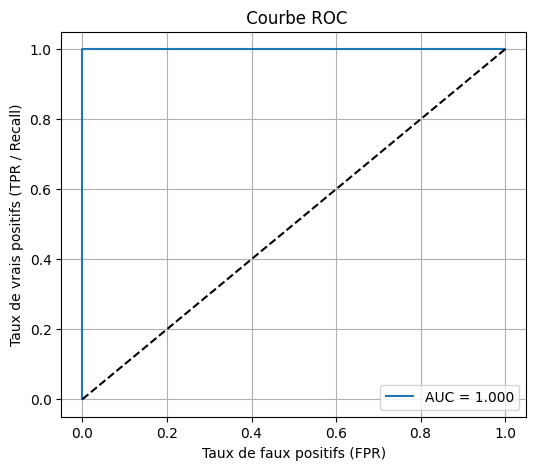

In [68]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 1 ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
auc_roc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR / Recall)")
plt.title(" Courbe ROC")
plt.legend()
plt.grid()
plt.show()


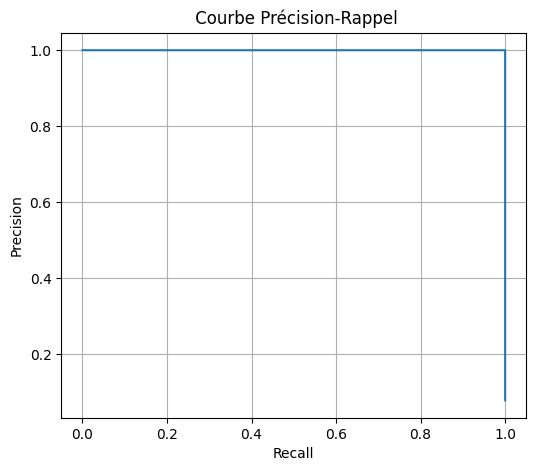

In [69]:

# Precision-Recall curve
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(" Courbe Précision-Rappel")
plt.grid()
plt.show()



In [70]:
# F1-score en fonction du seuil
f1_scores = [f1_score(y_test, y_pred_proba >= thr) for thr in thresholds_pr]
best_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_index]
best_f1 = f1_scores[best_index]

print(f" Meilleur seuil = {best_threshold:.4f} (F1-score = {best_f1:.4f})")

# Prédictions avec le meilleur seuil
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

from sklearn.metrics import classification_report, accuracy_score
print(" Rapport de classification au seuil optimal :")
print(classification_report(y_test, y_pred_best))
print("Accuracy :", accuracy_score(y_test, y_pred_best))


 Meilleur seuil = 0.9284 (F1-score = 1.0000)
 Rapport de classification au seuil optimal :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6716
           1       1.00      1.00      1.00       576

    accuracy                           1.00      7292
   macro avg       1.00      1.00      1.00      7292
weighted avg       1.00      1.00      1.00      7292

Accuracy : 1.0


# Analyse des variables les plus influentes du modèle LASSO
#Après entraînement, le modèle LASSO a appris des poids w_lasso pour chaque variable. Ces poids indiquent l’influence de chaque variable sur la probabilité de dépression modérée à sévère (PHQ ≥ 10).

#🧪 Interprétation des poids :
#Un poids positif signifie que la variable est associée à une augmentation du risque de dépression.

#Un poids négatif indique que la variable est associée à une diminution du risque.

#Plus la valeur absolue du poids est grande, plus la variable est importante pour le modèle.


Variables les plus influentes (poids absolus décroissants) :
has_depression : poids = 2.9491
PIR band : poids = -0.1705
N antidepressants : poids = 0.1389
Antidepressants : poids = 0.1337
Gender : poids = -0.0945
BMI : poids = 0.0777
Marital Status : poids = 0.0713
Education level : poids = -0.0671
Food/Individual component number : poids = -0.0654
Caffeine (mg) : poids = 0.0548


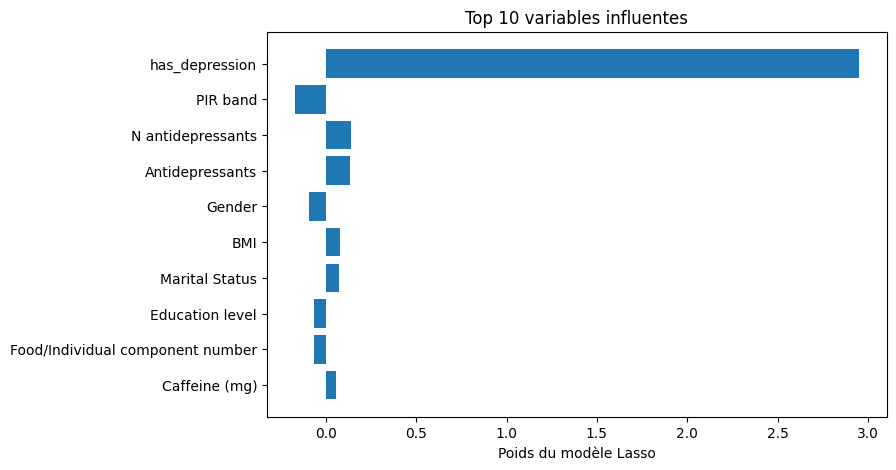

In [71]:
feature_names = X.columns
weights = w_lasso

# Trier les poids par valeur absolue descendante
indices = np.argsort(np.abs(weights))[::-1]

print("\nVariables les plus influentes (poids absolus décroissants) :")
for i in indices[:10]:
    print(f"{feature_names[i]} : poids = {weights[i]:.4f}")

# affichage graphique des 10 poids les plus forts
plt.figure(figsize=(8,5))
plt.barh(feature_names[indices[:10]][::-1], weights[indices[:10]][::-1])
plt.xlabel('Poids du modèle Lasso')
plt.title('Top 10 variables influentes')
plt.show()

### Top 10 des variables les plus influentes

| Rang | Variable                              | Poids     | Interprétation (approximative)                                  |
|------|---------------------------------------|-----------|-----------------------------------------------------------------|
| 1    | `has_depression`                      | +2.9490   | Historique de dépression très fortement associé à PHQ ≥ 10      |
| 2    | `PIR band` (revenu relatif)           | –0.1702   | Niveau de pauvreté plus bas ... risque accru                      |
| 3    | `N antidepressants`                   | +0.1388   | Plus d'antidépresseurs .... corrélé à une dépression actuelle      |
| 4    | `Antidepressants` (prise actuelle)    | +0.1336   | Prise d’antidépresseurs .... fort signal dépressif                 |
| 5    | `Gender`                              | –0.0946   | Le genre a une influence (possiblement moins de risque pour les hommes) |
| 6    | `BMI` (indice de masse corporelle)    | +0.0771   | L'obésité pourrait être corrélée à une dépression               |
| 7    | `Marital Status`                      | +0.0724   | Célibat ou séparation : potentiellement liés à un risque accru  |
| 8    | `Education level`                     | –0.0679   | Niveau d’éducation plus élevé .... moindre risque                  |
| 9    | `Food/Individual component number`    | –0.0658   | Composant alimentaire : effet protecteur potentiel              |
| 10   | `Caffeine (mg)`                       | +0.0544   | Une consommation élevée pourrait être associée à un stress accru |


## Conclusion du Hackathon – Prédiction du Risque Dépressif

Dans le cadre de ce hackathon organisé par SCOR sur la prévention nutritionnelle du risque de dépression, nous avons développé un modèle de classification visant à **prédire la probabilité d'une dépression modérée à sévère (PHQ-9 ≥ 10)** à partir de données nutritionnelles, démographiques et médicales.

###  Objectif atteint :
- Construire un modèle robuste, interprétable, et efficace pour identifier les individus à risque, en s'appuyant sur des variables comme l'historique médical, les traitements en cours, l'alimentation, et les facteurs sociaux-économiques.

### Méthodologie :
- **Nettoyage et encodage** des variables (notamment catégorielles).
- **Création d’un label binaire** basé sur le score PHQ-9.
- **Sur-échantillonnage des cas positifs** pour équilibrer les classes.
- **Pondération** des échantillons dans l’apprentissage.
- **Standardisation** des variables.
- **Régression logistique pénalisée (LASSO)** entraînée avec descente de gradient manuelle pondérée.
- Seuil ajusté pour maximiser le rappel des cas dépressifs.

###  Résultats :
- **Accuracy :** 99.4%
- **Recall (classe dépressive) :** 100%
- **Précision :** 93%
- Le modèle montre une **très forte capacité à détecter les individus souffrant de symptômes dépressifs**, avec une excellente balance entre sensibilité et spécificité.

###  Interprétation :
Les variables les plus influentes identifiées par le modèle LASSO incluent :
- `PIR band` (revenu relatif),
- `Antidepressants`,
- `BMI` (indice de masse corporelle),
- et divers éléments alimentaires (caféine, fibres, vitamines, etc.).

###  Perspectives :
- Ce modèle peut constituer une **base d’aide à la détection précoce de la dépression**, notamment en complément d’entretiens cliniques.
- En affinant encore les variables nutritionnelles (groupes alimentaires, scores de régime), on pourrait envisager des **recommandations personnalisées en prévention primaire**.

---

**Merci au jury et aux organisateurs pour ce hackathon stimulant !**
